In [8]:
# imports 
from __future__ import annotations
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import time
from typing import List, Tuple
from scipy.stats import norm
tfd = tfp.distributions

seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['figure.dpi'] = 80


In [13]:
class Create_Data():
    
    def __init__(self, vf, dim):
        super(Create_Data, self).__init__()
        self.vf = vf
        self.dim = dim
    
    def create_raw_data(self, train_n, bounds, test_n):
        # n is the number of points, bounds is a list of bounds for the d-dimensional data
        if self.dim == 2:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n)]).T
        elif self.dim == 3:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n),  np.random.uniform(-bounds[2],bounds[2],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n),  np.random.uniform(-bounds[2],bounds[2],test_n)]).T
        else:
            return('wrong dimensions')
        vfdata = self.vf(omega_domain)
        tdata = tf.convert_to_tensor(omega_domain, dtype=tf.float32)
        tvf     = kb.transpose(tf.convert_to_tensor(vfdata, dtype=tf.float32))
        test_vfdata = self.vf(test_omega_domain)
        test_tdata = tf.convert_to_tensor(test_omega_domain, dtype=tf.float32)
        test_tvf     = kb.transpose(tf.convert_to_tensor(test_vfdata, dtype=tf.float32))

        train_dataset_raw = tf.data.Dataset.from_tensor_slices((tdata, tvf))
        test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_tdata, test_tvf))

        return train_dataset_raw, test_dataset_raw, omega_domain, np.array(vfdata)
    
    def shuffle_and_batch_dataset(self, dataset, batch_size, shuffle_buffer=None):
        if shuffle_buffer:
            dataset = dataset.shuffle(buffer_size=shuffle_buffer)
            
        dataset = dataset.batch(batch_size)
        return(dataset)

In [14]:
# dimensions of the problem 
dim = 2
# number of data points
n = 90
# bounds of the x1 and x2
bounds = [1.6, 4]
# bounds = [2,2]
# number of points for the test dataset
test_n =90
batch_n = 90
buff = 1024

def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

In [15]:
n =20
# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

# X, Y = np.meshgrid(omega_domain[:,0], omega_domain[:,1])
s = X.shape
DT = np.zeros((n**2,dim))


# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, n, n))

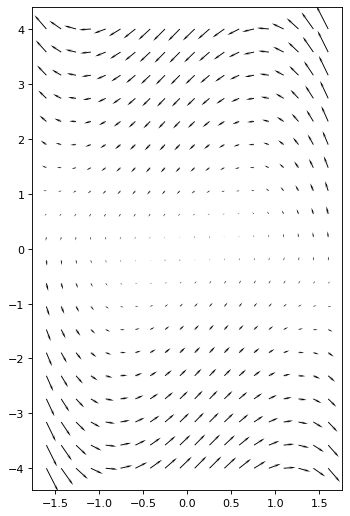

In [16]:
plt.figure(figsize=(5,8))
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=3, headlength=8)
plt.show()

In [17]:
my_data = Create_Data(vf, dim)
tr, te, omega_domain, vfdata = my_data.create_raw_data(n, bounds, test_n)
tr = my_data.shuffle_and_batch_dataset(tr, batch_n, buff)
# te = my_data.shuffle_and_batch_dataset(te, batch_n)

2022-06-21 18:19:48.954603: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
class Kernel:
    """Base class for kernels"""

    def __add__(self, kernel2: Kernel):
        return SumKernel([self, kernel2])

    def __mul__(self, kernel2: Kernel):
        return ProductKernel([self, kernel2])


class SumKernel:
    """Kernel to enable summation of kernels"""

    def __init__(self, kernels: List[Kernel]) -> None:
        self.kernels = kernels

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        return np.sum([k(X, X2) for k in self.kernels], axis=0)


class ProductKernel:
    """Kernel to enable product of kernels"""

    def __init__(self, kernels: List[Kernel]) -> None:
        self.kernels = kernels

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        return np.prod([k(X, X2) for k in self.kernels], axis=0)


class RBF(Kernel):
    def __init__(
        self, sigma_f: np.float64 = 1.0, lengthscale: np.float64 = 1.0
    ) -> None:
        self.sigma_f = sigma_f
        self.lengthscale = lengthscale

    def __call__(self, X: np.ndarray, X2: np.ndarray = None) -> np.ndarray:
        """
        Calculate a kernel matrix using the RBF kernel

        Args:
        - X: matrix with shape n1 x 1
        - X2: matrix with shape n2 x 1 or None (default), in which case X2=X

        Returns: n1 x n2 kernel matrix
        """

        if X2 is None:
            X2 = X

        # we make use of broadcasting to compute the pairwise difference
        # between each element of X and X2
        diff = (X[:, None, 0] - X2[None, :, 0]) ** 2
        K = self.sigma_f ** 2 * np.exp(-diff / (2 * self.lengthscale ** 2))
        return K

In [62]:
def A_i_j(x, y, K, g):    
    with tf.GradientTape() as tape:
        tape.watch(x)
        tape.watch(y)
        z = K.apply(x,y)
        print(z.shape)
        print('--'*50)
    dzdx, dzdy = tape.gradient(z, [x,y])
    print(dzdx.shape)
    vfx = tf.math.reduce_sum(dzdx*tf.transpose(tf.convert_to_tensor(g(x), dtype=tf.double)),axis=1)
    vfy = tf.math.reduce_sum(dzdy*tf.transpose(tf.convert_to_tensor(g(y), dtype=tf.double)),axis=1)

    product = tf.tensordot(vfx, vfy, axes=0)
    return product

In [63]:
def get_s(x, K, g):
    with tf.GradientTape() as tape:
        tape.watch(x)
        # not sure about the second argument of the kernel
        # z = K.apply(x)
        z = K(x)
        print(z.shape)
        z = tf.convert_to_tensor(z)
        print('--'*50)
        print(z.shape)
        dzdx = tape.gradient(z, x)
        print('--'*50)
        print(dzdx.shape)
        vfx = tf.math.reduce_sum(dzdx*tf.transpose(tf.convert_to_tensor(g(x), dtype=tf.double)),axis=1)
        return vfx


In [64]:
# x = tf.constant([tf.linspace(-5, 6, 90), tf.linspace(-5, 6, 90)])
x = tf.constant(omega_domain)
y = - tf.square(x)
# y = tf.constant(omega_domain + 1)
# y = tf.constant([tf.linspace(-2, 4, 90), tf.linspace(-2, 4, 90)])
g_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
product =A_i_j(x,y,g_kernel, vf)

(20,)
----------------------------------------------------------------------------------------------------
(20, 2)


In [65]:
# X =np.linspace(-bounds[0], bounds[0], 20)
# Y = np.linspace(-bounds[0]**2, bounds[0]**2, 20)

# cp = plt.contour(X,Y,product, levels=15)

In [66]:
beta = - tf.square(x)
alphas = tf.linalg.solve(product, beta)
alphas.shape

TensorShape([20, 2])

In [67]:
get_s(x, RBF(), vf)

(20, 20)
----------------------------------------------------------------------------------------------------
(20, 20)
----------------------------------------------------------------------------------------------------


AttributeError: 'NoneType' object has no attribute 'shape'

In [32]:
myrbf= RBF()
myrbf(x)

array([[1.        , 0.6243769 , 0.41068972, 0.93487096, 0.68798784,
        0.58289576, 0.76136291, 0.97419248, 0.99790174, 0.92686268,
        0.99997583, 0.69192267, 0.79346027, 0.33670165, 0.45964875,
        0.71972846, 0.99999959, 0.90234601, 0.67582708, 0.78240552],
       [0.6243769 , 1.        , 0.07024562, 0.40879057, 0.18555899,
        0.13276755, 0.23215495, 0.48719387, 0.58507899, 0.84478025,
        0.62858889, 0.99371018, 0.25600565, 0.88031023, 0.08556944,
        0.98735376, 0.62492529, 0.87479657, 0.17870888, 0.2475085 ],
       [0.41068972, 0.07024562, 1.        , 0.62647933, 0.89574535,
        0.95738739, 0.83743687, 0.54281545, 0.44684279, 0.22631551,
        0.40688846, 0.09043088, 0.80752577, 0.01931345, 0.99619884,
        0.10017953, 0.41019402, 0.20240726, 0.90416526, 0.81815919],
       [0.93487096, 0.40879057, 0.62647933, 1.        , 0.88344609,
        0.79789438, 0.93334469, 0.99047802, 0.95536682, 0.75101116,
        0.9324662 , 0.47208119, 0.95213118, 0